In [1]:
import torch 
import torch.nn as nn
from train import *
import os 
from pathlib import Path
from dynRNN.task import *
import matplotlib.pyplot as plt
from tqdm import trange

CONFIG = {
    'mem_size' : 128,
    'better_init_GRU': '2BiGRUf',
    'device': 'cpu'
}

run_name = 'flowing-frost-1012_b6o36w7o'

SCRATCH = os.environ.get('SCRATCH', '.')
PATH = Path(SCRATCH) / f'GRU_dyn/Cpy1in/runs/{run_name}/checkpoint.pth'

rnn, decoder = build(**CONFIG)
# mod = torch.load(PATH)

# rnn.load_state_dict(mod['rnn_check'])
# decoder.load_state_dict(mod['decoder_check'])

rnn.eval()
decoder.eval()

Linear(in_features=128, out_features=1, bias=True)

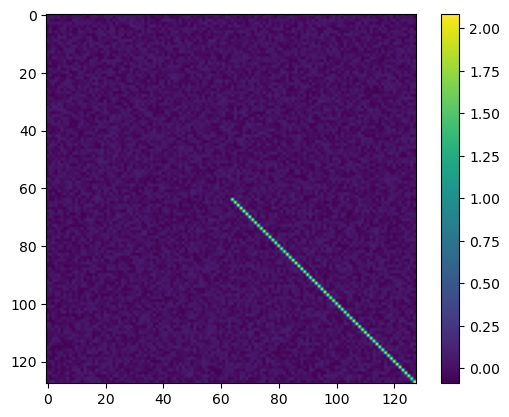

In [2]:
with torch.no_grad():
    plt.imshow(rnn.weight_hh_l0[2*CONFIG['mem_size']:3*CONFIG['mem_size']].cpu())
    plt.colorbar()
    plt.show()

if CONFIG['mem_size'] == 2:
    x = torch.linspace(-2, 2, 1000)
    y = torch.linspace(-1.1, 1.1, 1000)

    xy_grid = torch.meshgrid(x, y, indexing="ij")

    print(xy_grid)
    

torch.Size([2, 350, 1]) torch.Size([2, 350, 1])


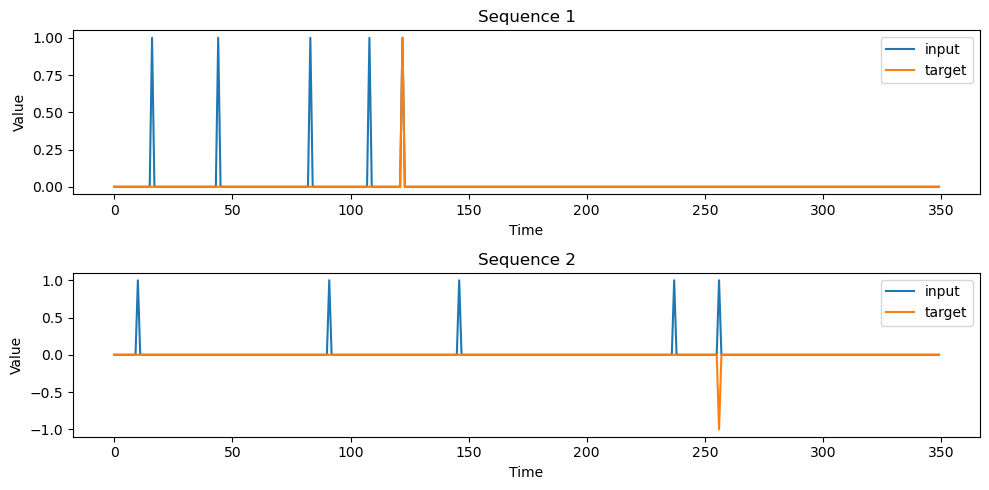

In [12]:
in_s, t_s = IntervalComparisonTask.get_batch(2)

print(in_s.shape,t_s.shape)
IntervalComparisonTask.plot_sequences(in_s,t_s)

In [32]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x):
        var, mu = torch.var_mean(x, dim = self.dim, keepdim = True, unbiased = True)
        # print(var, mu)
        return (x - mu)/(var + self.eps).sqrt()
    
class LowDimProj(nn.Module):
    def __init__(self, high_sz, proj_sz, hidden):
        super().__init__()
        self.act = nn.Tanh()
        self.encoder = nn.ModuleList([nn.Linear(i,j) for i,j in zip((high_sz,)+hidden, hidden+(proj_sz,))])
        hidden = tuple(reversed(hidden))
        self.decoder = nn.ModuleList([nn.Linear(i,j) for i,j in zip((proj_sz,)+hidden, hidden+(high_sz,))])
        self.norm = LayerNorm(-1)
        
    def encode(self,x):
        for e in self.encoder[:-1]:
            x = self.act(e(self.norm(x)))
        
        return self.encoder[-1](x)
    
    def decode(self,x):
        for d in self.decoder[:-1]:
            x = self.act(d(self.norm(x)))
        
        return self.decoder[-1](x)
    
    def loss(self, x, w=1e-3):
        Loss = nn.MSELoss()
        z = self.encode(x)
        
        return Loss(self.decode(z),x) + w*z.norm()
            
        
trajNet = LowDimProj(mask.sum(), 2, (64,32,16,8)).to(CONFIG['device'])
epoch = 2048
batch = 512
optim = torch.optim.AdamW(trajNet.parameters(), lr=1e-4, weight_decay=1e-4)
evaluate = 1024
data_eval = CopyFirstInput.get_batch(10, 300).to(CONFIG['device'])
with torch.no_grad():
    data_eval = rnn(data_eval)[0][:,:,mask]
    
    

0.22761444747447968:   0%|          | 0/2048 [00:00<?, ?it/s]

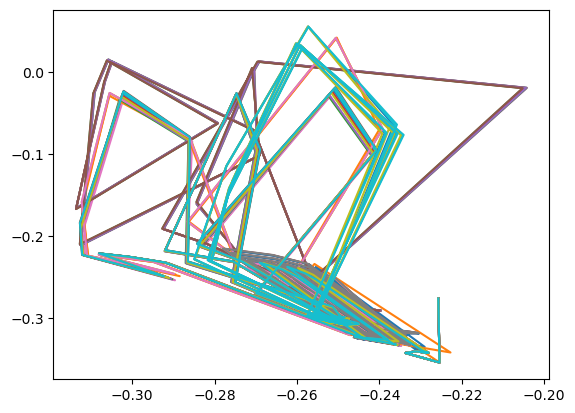

0.030048701912164688:  50%|█████     | 1024/2048 [02:23<02:21,  7.21it/s]

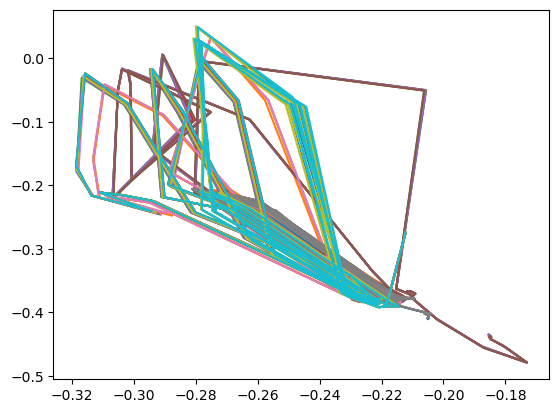

0.030074965208768845: 100%|██████████| 2048/2048 [04:45<00:00,  7.18it/s]


In [38]:
# for e in (pbar := trange(epoch)):
#     trajNet.train()
#     with torch.no_grad():
#         data = CopyFirstInput.get_batch(batch, 100)

#         traj = rnn(data.to(CONFIG['device']))[0]
    
#     l = trajNet.loss(traj,w=0)
#     pbar.set_description(str(l.item()))
#     l.backward()
#     optim.step()
#     optim.zero_grad()
    
#     if (e % evaluate) == 0:
#         trajNet.eval()
#         with torch.no_grad():
#             proj = trajNet.encode(data_eval)
#             for p in proj:
#                 plt.plot(p[:,0].cpu(),p[:,1].cpu())
#             plt.show()

for e in (pbar := trange(epoch)):
    trajNet.train()
    with torch.no_grad():
        data,_ = FreqDiscr.get_batch(batch)

        traj = rnn(data.to(CONFIG['device']))[0][:,:,mask]
        traj -= traj.mean(dim=-2,keepdim=True)
        
    l = trajNet.loss(traj,w=0)
    pbar.set_description(str(l.item()))
    l.backward()
    optim.step()
    optim.zero_grad()
    
    if (e % evaluate) == 0:
        trajNet.eval()
        with torch.no_grad():
            proj = trajNet.encode(data_eval)
            for p in proj:
                plt.plot(p[:,0].cpu(),p[:,1].cpu())
            plt.show()

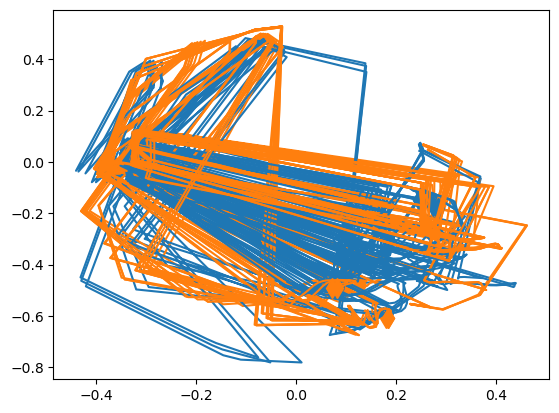

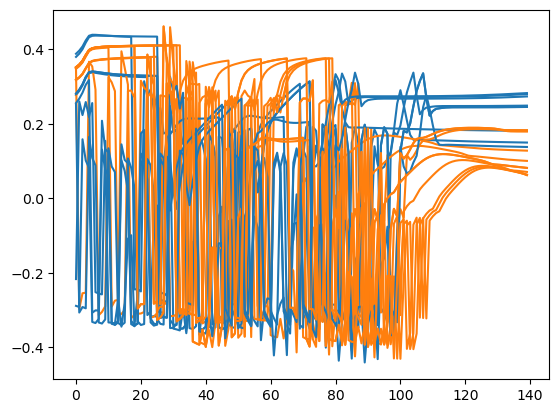

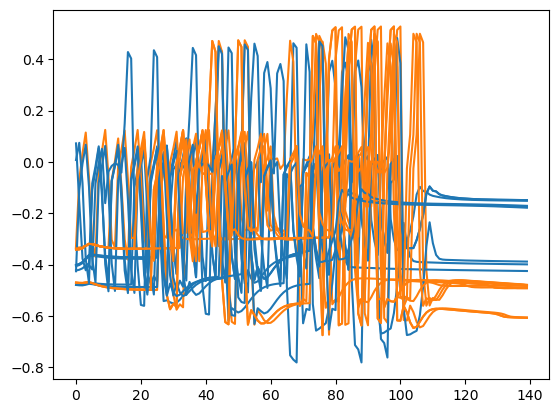

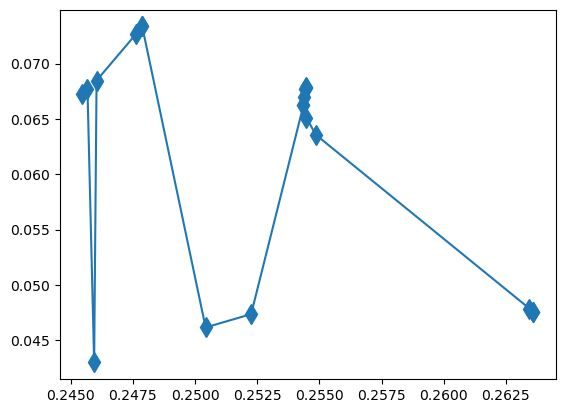

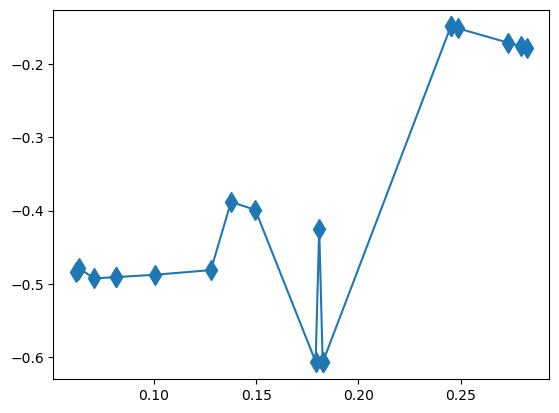

In [39]:
# data_eval = CopyFirstInput.get_batch(100, 300).to(CONFIG['device'])
# with torch.no_grad():
#     data_eval = rnn(data_eval)[0]
#     proj = data_eval#trajNet.encode(data_eval)
#     for p in proj:
#         plt.plot(p[:,0].cpu(),p[:,1].cpu())
#         plt.plot(p[-1,0].cpu(),p[-1,1].cpu(), marker='d', markersize=10)
#     plt.show()
#     for p in proj:
#         plt.plot(p[10:,0].cpu())
#     plt.show()
#     for p in proj:
#         plt.plot(p[10:,1].cpu())
#     plt.show()
    
#     x, idx = torch.sort(proj[:,0,0])
#     plt.plot(x.cpu(),proj[idx,0,1].cpu(), marker='d', markersize=10)
#     plt.show()
    
#     x, idx = torch.sort(proj[:,-1,0])
#     plt.plot(x.cpu(),proj[idx,-1,1].cpu(), marker='d', markersize=10)
#     plt.show()

data_eval,l = FreqDiscr.get_batch(20)
data_eval = data_eval.to(CONFIG['device'])

with torch.no_grad():
    data_eval = rnn(data_eval)[0][:,:,mask]
    data_eval -= data_eval.mean(dim=-2,keepdim=True)
    proj = trajNet.encode(data_eval)
    
    for i,p in enumerate(proj):
        col = 'C0' if l[i,-1] else 'C1'
        plt.plot(p[:,0].cpu(),p[:,1].cpu(),col)
        plt.plot(p[-1,0].cpu(),p[-1,1].cpu(), f'{col}d', markersize=10)
    plt.show()
    for i,p in enumerate(proj):
        col = 'C0' if l[i,-1] else 'C1'
        plt.plot(p[10:,0].cpu(),col)
    plt.show()
    for i,p in enumerate(proj):
        col = 'C0' if l[i,-1] else 'C1'
        plt.plot(p[10:,1].cpu(),col)
    plt.show()
    
    x, idx = torch.sort(proj[:,0,0])
    plt.plot(x.cpu(),proj[idx,0,1].cpu(), marker='d', markersize=10)
    plt.show()
    
    x, idx = torch.sort(proj[:,-1,0])
    plt.plot(x.cpu(),proj[idx,-1,1].cpu(), marker='d', markersize=10)
    plt.show()